# Truncated stick breaking in greta

Here, we briefly discuss truncated stick breaking (TSB). We use TSB as a finite-dimensional alternative to an infinite dimensional prior over number of mixture components. We do the analysis in `greta` (cause the author is more comfortable with it). We use the TSB, because it allows us to use continuous parameters entirely, which in turn allows us to use Hamiltonian Monte Carlo (and since most probabilistic programming languages do not allow discrete paramters :)). Also, in practice, working with continuous parameters is way easier than discrete ones (as with the Chinese restaurant process).

We first try to use TSB with a mixture of univariate normals, and then with Poisson variables.

Some required libraries:

In [1]:
suppressMessages(library("greta"))
suppressMessages(library("tensorflow"))

In [2]:
suppressMessages(library("tidyverse"))
suppressMessages(library("MASS"))
suppressMessages(library("bayesplot"))
options(repr.plot.width=8, repr.plot.height=3)

Reproducibility!

In [3]:
options(repr.plot.width=8, repr.plot.height=3)
set.seed(23)

### Normal data

We first create some data.

In [4]:
N <- 1000
K <- 3

In [5]:
mus <- c(-2, 0, 2)
sd <- .25

In [6]:
data <- vector(length = N * K)
for (k in seq(K)) {    
    idx <- seq(N) + ((k - 1) * N)
    data[idx] <- rnorm(N, mus[k], sd)
}

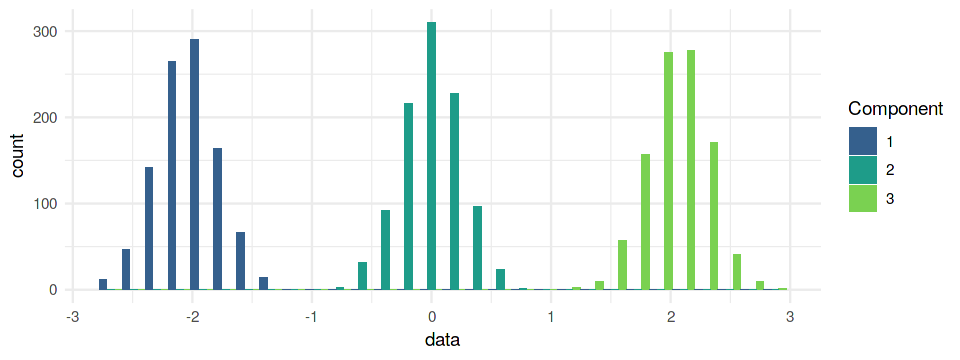

In [7]:
data.frame(data=data, idx=as.factor(rep(seq(K), each=N))) %>%
    ggplot(aes(data, fill=idx)) +
    geom_histogram(bins=30, position = "dodge") +
    scale_fill_viridis_d("Component", alpha = 1, begin=.3, end=.8) + 
    theme_minimal()

For our data set it should be fairly easy to find the correct number of clusters ($3$). For the TSB, we need to set the number of clusters to a sufficiently high $K$, to achieve a negligibly small error in comparison to a "true" infinite dimensional prior.

See for instance https://projecteuclid.org/euclid.bj/1551862850 for a theoretical and practical justification for the truncation.

In [8]:
K <- 10

We will only try to estimate the vector of mean values of the Gaussians. In order to avoid non-identifiability, we can use a small trick: we create a prior of means of length $K$ and, use the cumulative sum (`cumsum`), and ensure that the mean values are sorted and increasing in value. For instance:

In [9]:
x <- c(runif(1, -1, 1), runif(5, 0, 1))
cumsum(x)

[1] 0.5934549 0.8562308 1.2266048 2.0278573 2.6781344 3.1357224

In greta that is:

In [10]:
prior_mu_ordered <- cumsum(
    c(greta::variable(lower = -5, upper = 5),
      greta::variable(lower = 0, upper = 5, dim = K - 1)))

Then we set a prior over the mixing weights. For this, as mentioned before, we use stick breaking. Luckily `LaplacesDemon` has a function for the sticks.

In [11]:
stick_breaking <- function(theta) {
   LaplacesDemon::Stick(theta)
}

# note the K - 1 which is required for LaplacesDemon::Stick (yes it's dumb)
prior_stick <- greta::beta(1, 1, dim = K - 1)
prior_weights <- stick_breaking(prior_stick)

Then we set the mixture distribution and sample from the posterior. This is a little annoying in `R`, cause we need to do it manually.

In [12]:
greta::distribution(data) <- greta::mixture(
    greta::normal(prior_mu_ordered[1], .25),    
    greta::normal(prior_mu_ordered[2], .25),
    greta::normal(prior_mu_ordered[3], .25),
    greta::normal(prior_mu_ordered[4], .25),
    greta::normal(prior_mu_ordered[5], .25),
    greta::normal(prior_mu_ordered[6], .25),
    greta::normal(prior_mu_ordered[7], .25),
    greta::normal(prior_mu_ordered[8], .25),
    greta::normal(prior_mu_ordered[9], .25),
    greta::normal(prior_mu_ordered[10], .25),
    weights = prior_weights
)

In [13]:
mod <- greta::model(prior_stick, prior_weights, prior_mu_ordered)

In [14]:
samples <- greta::mcmc(mod, n_cores = 1, chains = 1)

    warmup ====================================== 1000/1000 | eta:  0s          
  sampling ====================================== 1000/1000 | eta:  0s          


Let's see if we could identify the components.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


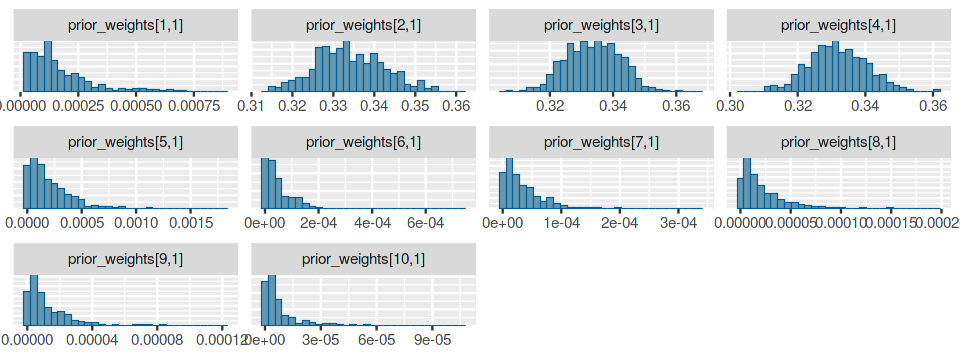

In [15]:
bayesplot::mcmc_hist(samples, regex_pars = "weights")

Looks like it suffices to use three components (as only three components of the weight posterior significant weight). Now, let's see if we could identify the means correctly. Since we only use components , we only consider these means.

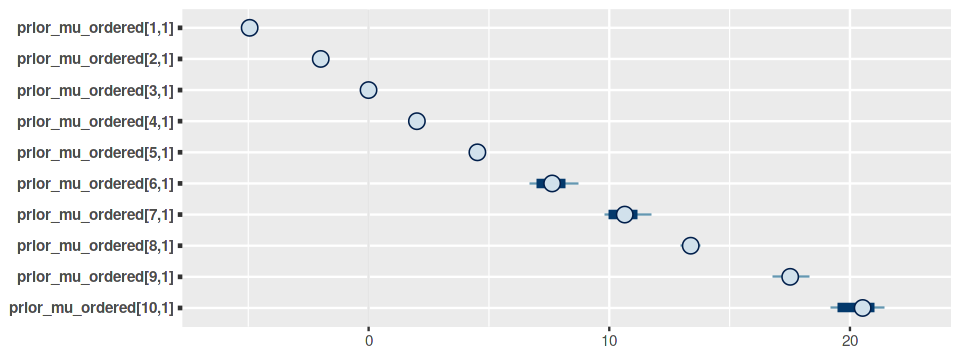

In [16]:
bayesplot::mcmc_intervals(samples, regex_pars = "mu")

Nice! That worked great. We were perfectly able to recover the correct number of components.

### Poisson data 

Next we try a Poisson mixture.

In [17]:
N <- 1000
K <- 3
mus <- exp(c(0, 1, 2))

In [18]:
data <- vector(length = N * K)
for (k in seq(K)) {    
    idx <- seq(N) + ((k - 1) * N)
    data[idx] <- rpois(N, mus[k])
}

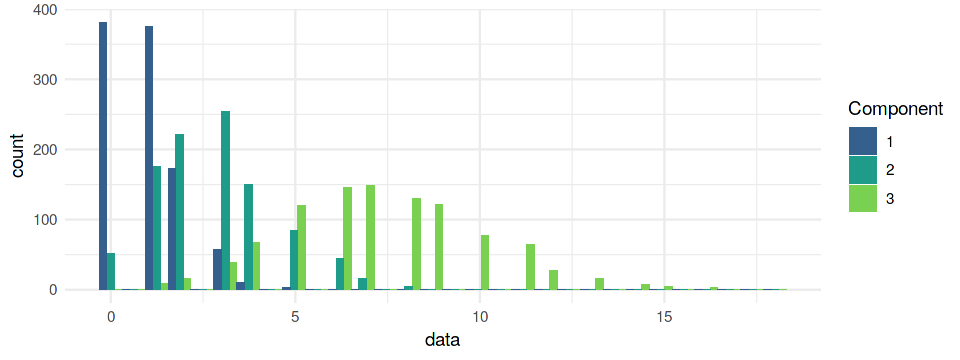

In [19]:
data.frame(data=data, idx=as.factor(rep(seq(K), each=N))) %>%
    ggplot(aes(data, fill=idx)) +
    geom_histogram(bins=30, position = "dodge") +
    scale_fill_viridis_d("Component", alpha = 1, begin=.3, end=.8) + 
    theme_minimal()

We truncate the DP at $K=10$ as before and define the model.

In [20]:
K <- 10

We can use the same the trick from before. Since we exponentiate the means later, we don't need to care about negative values.

In [21]:
prior_mu_ordered <- cumsum(
    c(greta::variable(lower = -5, upper = 3),
      greta::variable(lower = 0, upper = 3, dim = K - 1)))

In [22]:
greta::distribution(data) <- greta::mixture(
    greta::poisson(exp(prior_mu_ordered[1])),
    greta::poisson(exp(prior_mu_ordered[2])),
    greta::poisson(exp(prior_mu_ordered[3])),
    greta::poisson(exp(prior_mu_ordered[4])),
    greta::poisson(exp(prior_mu_ordered[5])),
    greta::poisson(exp(prior_mu_ordered[6])),
    greta::poisson(exp(prior_mu_ordered[7])),
    greta::poisson(exp(prior_mu_ordered[8])),
    greta::poisson(exp(prior_mu_ordered[9])),
    greta::poisson(exp(prior_mu_ordered[10])),
    weights = prior_weights
)

In [23]:
mod <- greta::model(prior_stick, prior_weights, prior_mu_ordered)

In [24]:
samples <- greta::mcmc(mod, chains = 1, n_cores = 1)

    warmup ====================================== 1000/1000 | eta:  0s          
  sampling ====================================== 1000/1000 | eta:  0s          


How many components do we need?

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


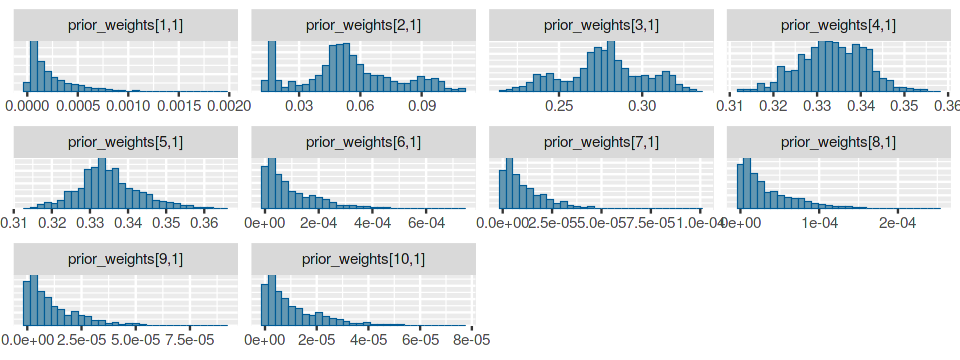

In [25]:
bayesplot::mcmc_hist(samples, regex_pars = "weights")

Here, it's not so clear anymore. It looks as if we should use four components (so one too many), but this could be due to poor prior choice. What about the means?

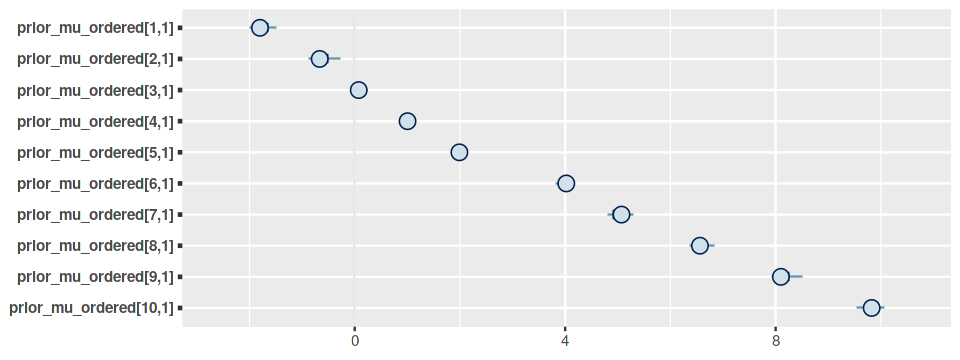

In [26]:
bayesplot::mcmc_intervals(samples, regex_pars = "mu")